In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.metrics import mean_squared_error
import time



In [2]:
df = pd.read_csv("/kaggle/input/nifty50-stock-market-data/ADANIPORTS.csv",index_col='Date')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3322 entries, 2007-11-27 to 2021-04-30
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Symbol              3322 non-null   object 
 1   Series              3322 non-null   object 
 2   Prev Close          3322 non-null   float64
 3   Open                3322 non-null   float64
 4   High                3322 non-null   float64
 5   Low                 3322 non-null   float64
 6   Last                3322 non-null   float64
 7   Close               3322 non-null   float64
 8   VWAP                3322 non-null   float64
 9   Volume              3322 non-null   int64  
 10  Turnover            3322 non-null   float64
 11  Trades              2456 non-null   float64
 12  Deliverable Volume  3322 non-null   int64  
 13  %Deliverble         3322 non-null   float64
dtypes: float64(10), int64(2), object(2)
memory usage: 389.3+ KB


In [3]:
df_final = df[["Prev Close", "Open", "High", "Low", "Volume", "Close"]]
df_final.head()

,Prev Close,Open,High,Low,Volume,Close
Date,,,,,,
2007-11-27,440.00,770.00,1050.00,770.0,27294366,962.90
2007-11-28,962.90,984.00,990.00,874.0,4581338,893.90
2007-11-29,893.90,909.00,914.75,841.0,5124121,884.20
2007-11-30,884.20,890.00,958.00,890.0,4609762,921.55
2007-12-03,921.55,939.75,995.00,922.0,2977470,969.30


In [4]:
ALL_FEATURES_CODE = 31
SCALER = MinMaxScaler(feature_range=(0, 1))
FEATURES_DICT = {1:"Prev Close", 2:"Open", 4:"High", 8:"Low", 16:"Volume"}
NUM_SPLITS = 5

def get_scaled_train_test(df,features_code,splits):
    features_dict = FEATURES_DICT
    selected_features = []
    
    if features_code==0:
        print("Error: Need atleast 1 feature, exiting...")
        return

    for key,value in features_dict.items():
        if key & features_code != 0:
            selected_features.append(value)
    
    X = df[selected_features].to_numpy()
    Y = df[["Close"]].to_numpy()

    print("Shape of X:",X.shape)
    print("Shape of Y:",Y.shape)

    X = SCALER.fit_transform(X)
    Y = SCALER.fit_transform(Y)

    kf = KFold(n_splits=splits)

    ind = kf.split(X)

    data = []
    for train_ind, test_ind in ind:
      X_train, X_test = X[train_ind], X[test_ind]
      Y_train, Y_test = Y[train_ind], Y[test_ind]
      data.append([X_train, X_test, Y_train, Y_test])
  
    return data

In [5]:
qw = get_scaled_train_test(df_final,31,NUM_SPLITS)

Shape of X: (3322, 5)
Shape of Y: (3322, 1)


In [6]:
def create_lstm_data(features,target,window_size=1):
    X, Y = [], []
    for i in range(len(features)-window_size-1):
        X.append(features[i:(i+window_size),:])        
        Y.append(target[i + window_size,:])
    return np.array(X), np.array(Y)

In [7]:
import math
import keras.backend as K
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping

def lstm_model(X_train,Y_train,num_of_units=30):
    K.clear_session()
    model = Sequential()
    model.add(LSTM(num_of_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(X_train, Y_train, epochs=100, batch_size=64, callbacks=[EarlyStopping(monitor='loss', patience=5, verbose=1)], verbose=1, shuffle=False)
    return model


In [8]:
def get_rms_from_scaled(Y_actual,Y_predict):
    a = SCALER.inverse_transform(Y_actual)
    p = SCALER.inverse_transform(Y_predict)
    return np.sqrt(mean_squared_error(a[:,0], p[:,0]))

# Manual Checking (Hit and Trial Method)
All Features, 30 days Window Size, 30 Number of units in LSTM model

In [9]:
start = time.time()

data  = get_scaled_train_test(df_final,ALL_FEATURES_CODE,NUM_SPLITS)

train_rms, test_rms = [], []
for s in range(NUM_SPLITS):
  print('Flod number: ',s)
  X_tr, X_ts, Y_tr, Y_ts = data[s][0], data[s][1], data[s][2], data[s][3]
  X_tr,Y_tr = create_lstm_data(X_tr,Y_tr,30)
  X_ts,Y_ts = create_lstm_data(X_ts,Y_ts,30)

  model =  lstm_model(X_tr,Y_tr,30)

  predict_tr = model.predict(X_tr)
  predict_ts = model.predict(X_ts)

  train_rms.append(get_rms_from_scaled(Y_tr,predict_tr))
  test_rms.append(get_rms_from_scaled(Y_ts,predict_ts))

print('Train Root Mean Squared Error:',sum(train_rms)/len(train_rms))
print('Test Root Mean Squared Error:',sum(test_rms)/len(test_rms))

end = time.time()
print("Time taken is " + str(end - start))

Shape of X: (3322, 5)
Shape of Y: (3322, 1)
Flod number:  0


2022-11-27 10:20:47.349853: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 10:20:47.492644: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 10:20:47.493471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-27 10:20:47.494840: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/100


2022-11-27 10:20:52.314597: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


42/42 [==============================] - 3s 4ms/step - loss: 0.0017
Epoch 2/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 3/100
42/42 [==============================] - 0s 3ms/step - loss: 8.4567e-04
Epoch 4/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 5/100
42/42 [==============================] - 0s 3ms/step - loss: 0.0016
Epoch 6/100
42/42 [==============================] - 0s 3ms/step - loss: 6.1195e-04
Epoch 7/100
42/42 [==============================] - 0s 3ms/step - loss: 5.4696e-04
Epoch 8/100
42/42 [==============================] - 0s 3ms/step - loss: 6.4784e-04
Epoch 9/100
42/42 [==============================] - 0s 3ms/step - loss: 6.8168e-04
Epoch 10/100
42/42 [==============================] - 0s 3ms/step - loss: 6.2853e-04
Epoch 11/100
42/42 [==============================] - 0s 3ms/step - loss: 7.0095e-04
Epoch 12/100
42/42 [==============================] - 0s 3ms/step - loss: 7.4072e-04
Epoch 00012: earl

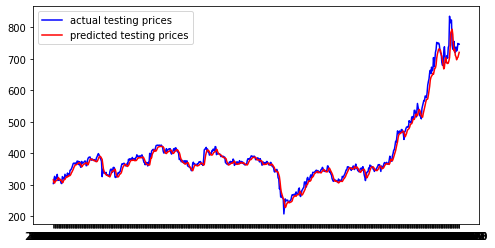

In [10]:
dates = df_final.index.to_numpy()
# print(dates[-len(Y_ts):].shape)
# Y_ts.shape
plt.figure(figsize=(8,4))
plt.plot(dates[-len(Y_ts):],SCALER.inverse_transform(Y_ts),color='blue',label='actual testing prices')
plt.plot(dates[-len(Y_ts):],SCALER.inverse_transform(predict_ts),color='r',label='predicted testing prices')
plt.legend(loc='best')
plt.show()

# GA Optimization

In [11]:
pip install deap

Note: you may need to restart the kernel to use updated packages.


In [12]:
!pip install bitarray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 519.4 kB/s eta 0:00:00


In [13]:
from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitarray import bitarray as BitArray
from bitarray.util import ba2int

def train_evaluate(ga_individual_solution):
    
    window_size_bits = BitArray(ga_individual_solution[0:6])
    num_of_units_bits = BitArray(ga_individual_solution[6:13])
    features_code_bits = BitArray(ga_individual_solution[13:])
    window_size = ba2int(window_size_bits)
    num_of_units = ba2int(num_of_units_bits)
    features_code = ba2int(features_code_bits)
    print('\nWindow Size: ', window_size, ', Num of Units: ', num_of_units, ', Features Code: ', features_code)

    if window_size == 0 or num_of_units == 0 or features_code == 0:
        return 10000,

    data = get_scaled_train_test(df_final,features_code,NUM_SPLITS)
    
    val_rms = []
    for s in range(NUM_SPLITS):
      X_tr, X_val, Y_tr, Y_val = data[s][0], data[s][1], data[s][2], data[s][3]
      
      X_tr,Y_tr = create_lstm_data(X_tr,Y_tr,30)
      X_val,Y_val = create_lstm_data(X_val,Y_val,30)

      model =  lstm_model(X_tr,Y_tr,num_of_units)

      predict_val = model.predict(X_val)

      val_rms.append(get_rms_from_scaled(Y_val,predict_val))

    rmse = sum(val_rms)/len(val_rms)

    print('Validation RMSE: ', rmse,'\n')

    return rmse,

In [14]:
start = time.time()

MU = LAMBDA = population_size = 20
num_generations = 20
gene_length = 18

creator.create('FitnessMin', base.Fitness, weights = (-1.0,))
creator.create('Individual', list , fitness = creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary,
n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selBest)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
r = algorithms.eaMuPlusLambda(population, toolbox, mu=MU, lambda_=LAMBDA, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end = time.time()
print("Time taken is " + str(end - start))


Window Size:  39 , Num of Units:  103 , Features Code:  25
Shape of X: (3322, 3)
Shape of Y: (3322, 1)
Epoch 1/100
42/42 [==============================] - 1s 4ms/step - loss: 0.0014
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 9.3834e-04
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 7.3496e-04
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 5.3827e-04
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 0.0013
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 9.7486e-04
Epoch 7/100
42/42 [==============================] - 0s 4ms/step - loss: 7.1829e-04
Epoch 8/100
42/42 [==============================] - 0s 4ms/step - loss: 8.2410e-04
Epoch 9/100
42/42 [==============================] - 0s 4ms/step - loss: 6.4844e-04
Epoch 00009: early stopping
Epoch 1/100
42/42 [==============================] - 1s 4ms/step - loss: 0.0212
Epoch 2/100
42/42 [=====================

In [15]:
best_individuals = tools.selBest(population,k = 1)
print(best_individuals[0].fitness)
print(best_individuals[0].fitness.values)
window_size_bits = BitArray(best_individuals[0][0:6])
num_of_units_bits = BitArray(best_individuals[0][6:13])
features_code_bits = BitArray(best_individuals[0][13:])
best_window_size = ba2int(window_size_bits)
best_num_of_units = ba2int(num_of_units_bits)
best_features_code = ba2int(features_code_bits)
print('\nBest Window Size: ', best_window_size, ', Best Num of Units: ', best_num_of_units, ', Best Features Code: ', best_features_code)

(17.71359183515751,)
(17.71359183515751,)

Best Window Size:  63 , Best Num of Units:  126 , Best Features Code:  28


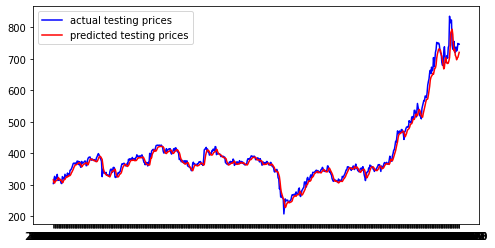

In [16]:
dates = df_final.index.to_numpy()
plt.figure(figsize=(8,4))
plt.plot(dates[-len(Y_ts):],SCALER.inverse_transform(Y_ts),color='blue',label='actual testing prices')
plt.plot(dates[-len(Y_ts):],SCALER.inverse_transform(predict_ts),color='r',label='predicted testing prices')
plt.legend(loc='best')
plt.show()